<a href="https://colab.research.google.com/github/vidiazg/analisis_hidrogeoq/blob/main/Informe2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Informe N° 2 Deep Learning

### Viviana Carolina Diaz - 04.12.2022

Código Fuente L. F. Isikdogan: 
https://github.com/isikdogan/deepwatermap

Aplicación del modelo DeepWaterMap una red neuronal convolucional para identificar cuerpos de agua a partir de imagenes multiespectrales 

### 1. Paso 

Cargar las librerias necesarias para correr el modelo Deepwater

In [ ]:
import tensorflow

In [ ]:
import tifffile as tif  ## leer datos tif

In [ ]:
!pip install rasterio ## leer datos raster

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import rasterio
from rasterio.plot import show

#img = rasterio.open("image.tif")

In [ ]:
# These imports let you use opencv
import cv2 #opencv itself

In [ ]:
#import common #some useful opencv functions
import numpy as np # matrix manipulations

#the following are to do with this interactive notebook code
%matplotlib inline 
from matplotlib import pyplot as plt # this lets you draw inline pictures in the notebooks
import pylab # this allows you to control figure size 
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # this controls figure size in the notebook

In [ ]:
!pip install imagecodecs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import imagecodecs

### 2. Paso 

Definir directorio de trabajo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('drive/MyDrive/PRA/INFO2')

In [ ]:
!pwd

/content/drive/MyDrive/PRA/INFO2


In [ ]:
!ls 

checkpoints	 inference.py	 outputs      sample_data
data_tools	 Informe2.ipynb  __pycache__  trainer.py
deepwatermap.py  metrics.py	 README.md


### 3. Paso

Visualizar imagenes 

Se cargará la imagen correspondiente al área de estudio que se localiza en la región del MUNICIPIO DE TALAIGUA NUEVO, caracterizado por encontrarse entre la zona de inundación del río Magdalena y Brazo de Mompós.

Se utilizó una imagen Sentinel 2, tomada el 25 de diciembre de 2018

In [ ]:
!ls sample_data

IMAGEN1.tif  IMAGEN.tif


In [ ]:
# read using opencv
img1 = cv2.imread('./sample_data/IMAGEN1.tif', cv2.IMREAD_ANYDEPTH | cv2.IMREAD_UNCHANGED)

In [ ]:
import imagecodecs

# read using tifffile
from imagecodecs import tiff_encode
from imagecodecs import imwrite, imread


In [ ]:
img2 = tif.imread('./sample_data/IMAGEN1.tif')

In [ ]:
# read using rasterio
img3 = rasterio.open("./sample_data/IMAGEN1.tif")

In [ ]:
type(img2)

numpy.ndarray

In [ ]:
type(img3)

rasterio.io.DatasetReader

In [ ]:
print(img2.shape)

(225, 248, 6)


In [ ]:
print(np.nanmin(img2), np.nanmean(img2), np.nanmax(img2), np.nanstd(img2))

0.0015 0.10084234 0.6707 0.09662999


In [ ]:
img = (img2/255)

In [ ]:
print(np.nanmin(img), np.nanmean(img), np.nanmax(img))

5.882353e-06 0.0003954602 0.002630196


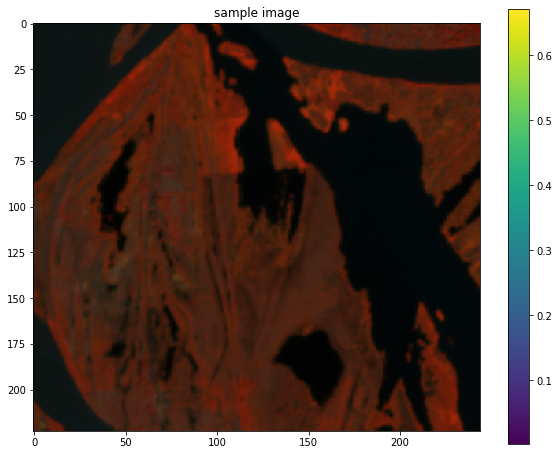

In [ ]:
plt.imshow(img2[1:224, 1:245, [4,3,2]])
plt.title('sample image')
plt.colorbar()

### 4. Paso

Inferencia 

A partir del modelo Deepwater se realizará una inferencia en nuestro conjunto de datos

In [ ]:
import deepwatermap, inference

In [ ]:
!ls checkpoints

cp.135.ckpt.data-00000-of-00001  cp.135.ckpt.index


In [ ]:
!python inference.py --checkpoint_path checkpoints/cp.135.ckpt \
    --image_path sample_data/IMAGEN1.tif --save_path outputs/IMAGEN1_water.tif

2022-12-05 00:58:56.774054: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
1/1 [==============================] - 7s 7s/step


Cargar la imagen creada a partir de la inferencia

In [ ]:
imgwater = tif.imread('./outputs/IMAGEN1_water.tif')

In [ ]:
img1 = cv2.imread('./outputs/IMAGEN1_water.png')

In [ ]:
type(imgwater)

numpy.ndarray

## IMPORTANTE

Convertir a tipo de dato tensor.float32

In [ ]:
imgwater1 = tensorflow.cast(imgwater, tensorflow.float32)

In [ ]:
type(imgwater1)

tensorflow.python.framework.ops.EagerTensor

Visualizar el resultado

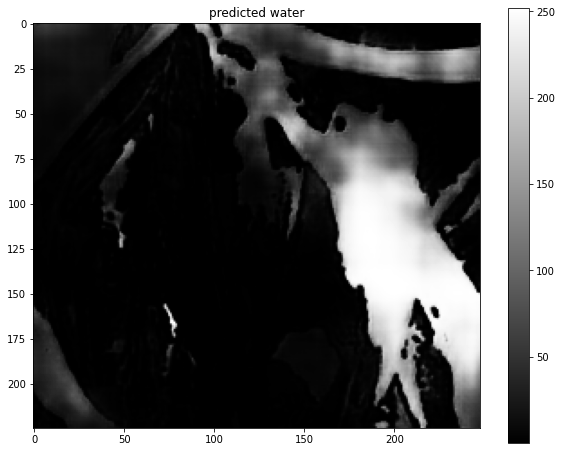

In [ ]:
#Create the display image and plot it
plt.imshow(imgwater, cmap="gray")
plt.title('predicted water')
plt.colorbar()

### 5. Paso

Evaluación de la calidad cuantitativa de los resultados

Primero se importa metrics.py del modelo DeepWater para evaluar la exactitud de los resultados

In [ ]:
import metrics

Se carga la imagen con la información de la cobertura rasterizada para evaluar la exactitud de los resultados

In [ ]:
imgtrue = tif.imread('./outputs/trdata1.tif')

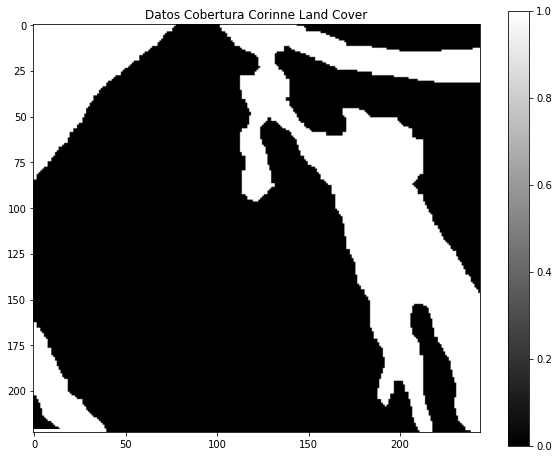

In [ ]:
#Create the display image and plot it
plt.imshow(imgtrue[1:224, 1:245], cmap="gray", vmin = 0, vmax = 1)
plt.title('Datos Cobertura Corinne Land Cover')
plt.colorbar()

IMPORTANTE
Convertir a tipo de dato tensor.float32

In [ ]:
imgtrue1 = tensorflow.cast(imgtrue, tensorflow.float32)

In [ ]:
type(imgtrue1)

tensorflow.python.framework.ops.EagerTensor

Estimar la exactitud con las funciones 


1.   running_recall
2.   running_precision
2.   running_f1




In [ ]:
metrics.running_recall(imgtrue1, imgwater1)

<tf.Tensor: shape=(), dtype=float32, numpy=0.99736506>

In [ ]:
metrics.running_precision(imgtrue1, imgwater1)

<tf.Tensor: shape=(), dtype=float32, numpy=0.3474437>

In [ ]:
metrics.running_f1(imgtrue1, imgwater1)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5153568>